In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install accelerate peft bitsandbytes transformers trl seqeval evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 24.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01

In [13]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification, pipeline
from datasets import Dataset
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
train_df = pd.read_csv("/kaggle/input/laptop-absa/train.csv")
eval_df = pd.read_csv("/kaggle/input/laptop-absa/eval.csv")
test_df = pd.read_csv("/kaggle/input/laptop-absa/test.csv")


In [15]:
label2id = {
    "O": 0,
    "B-ASP": 1, "I-ASP": 2,
    "B-BRAND": 3, "I-BRAND": 4,
    "B-COLOR": 5, "I-COLOR": 6,
    "B-FEATURE": 7, "I-FEATURE": 8,
}
id2label = {v: k for k, v in label2id.items()}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'O': 0, 'B-ASP': 1, 'I-ASP': 2, 'B-BRAND': 3, 'I-BRAND': 4, 'B-COLOR': 5, 'I-COLOR': 6, 'B-FEATURE': 7, 'I-FEATURE': 8}
id2label: {0: 'O', 1: 'B-ASP', 2: 'I-ASP', 3: 'B-BRAND', 4: 'I-BRAND', 5: 'B-COLOR', 6: 'I-COLOR', 7: 'B-FEATURE', 8: 'I-FEATURE'}


In [16]:
def make_ner_tags(row):
    tokens = row["text"].split()
    tags = ["O"] * len(tokens)

    for ann in eval(row["annotations"]):
        target = ann[0]
        category = ann[1].lower() 
        if target == "null":
            continue
            
        if "brand" in category:
            label_type = "BRAND"
        elif "color" in category:
            label_type = "COLOR"
        elif "feature" in category:
            label_type = "FEATURE"
        else:
            label_type = "ASP"

        tks = target.split()
        target_len = len(tks)

        for i in range(len(tokens) - target_len + 1):
            if tokens[i:i+target_len] == tks and all(tag == "O" for tag in tags[i:i+target_len]):
                tags[i] = f"B-{label_type}"
                for j in range(1, target_len):
                    tags[i + j] = f"I-{label_type}"
                break  # Stop after first match of this annotation

    print(f"\n[NER TAGGING]")
    print(f"Original Text: {row['text']}")
    print(f"Tokens: {tokens}")
    print(f"NER Tags: {tags}")
    return tokens, [label2id[tag] for tag in tags]


In [17]:
for df_name, df in zip(["train", "eval", "test"], [train_df, eval_df, test_df]):
    proc = df.apply(make_ner_tags, axis=1, result_type="expand")
    df[["tokens", "ner_tags"]] = proc
    print(f"\nSample from {df_name}_df after tagging:")
    print(df[["text", "tokens", "ner_tags"]].iloc[0])



[NER TAGGING]
Original Text: acer wants $ 170 to just look at it then add the repair cost on top of that .
Tokens: ['acer', 'wants', '$', '170', 'to', 'just', 'look', 'at', 'it', 'then', 'add', 'the', 'repair', 'cost', 'on', 'top', 'of', 'that', '.']
NER Tags: ['B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

[NER TAGGING]
Original Text: update : i repaired it myself for $ 12 .
Tokens: ['update', ':', 'i', 'repaired', 'it', 'myself', 'for', '$', '12', '.']
NER Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

[NER TAGGING]
Original Text: i had nothing to lose since it was a paper weight otherwise .
Tokens: ['i', 'had', 'nothing', 'to', 'lose', 'since', 'it', 'was', 'a', 'paper', 'weight', 'otherwise', '.']
NER Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

[NER TAGGING]
Original Text: the shame of it is knowing it took me 15 minutes and $ 12 to fix it and acer wanted to rob me of $ 170 just to look at

In [18]:
from collections import Counter
all_labels = [label for seq in train_df['ner_tags'] for label in seq]
label_counts = Counter(all_labels)
print(label_counts)


Counter({0: 43161, 1: 1928, 2: 786, 7: 299, 8: 128})


In [19]:

datasets = {
    'train': Dataset.from_pandas(train_df),
    'eval': Dataset.from_pandas(eval_df),
    'test': Dataset.from_pandas(test_df),
}

In [ ]:
model_ckpt = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


In [ ]:
def tokenize_ner(batch):
    tokenized = tokenizer(batch["tokens"], is_split_into_words=True, truncation=True, padding="max_length", max_length=128)
    labels = []

    for i, word_ids in enumerate(tokenized.word_ids(batch_index=i) for i in range(len(batch["tokens"]))):
        label = []
        prev = None
        for word_idx in word_ids:
            if word_idx is None:
                label.append(-100)
            elif word_idx != prev:
                label.append(batch["ner_tags"][i][word_idx])
            else:
                label.append(-100)  # ignore subword pieces in the loss
            prev = word_idx
        labels.append(label)

    tokenized["labels"] = labels
    return tokenized


for split in ["train", "eval", "test"]:
    datasets[split] = datasets[split].map(tokenize_ner, batched=True)
    datasets[split] = datasets[split].remove_columns([c for c in datasets[split].column_names if c not in ["input_ids", "attention_mask", "labels"]])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
base_model = AutoModelForTokenClassification.from_pretrained(
    "microsoft/deberta-v3-base",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)
base_model.to(device)


In [ ]:
# Configure LoRA parameters
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_proj", "value_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.TOKEN_CLS
)

In [ ]:
# Apply LoRA to the base model
model = get_peft_model(base_model, lora_config)
model.to(device)


In [ ]:
# Calculate class weights properly for all classes
num_classes = len(label2id)  # Should be 9 based on your label2id dictionary
print(f"Number of classes: {num_classes}")


In [ ]:
# Initialize weights for all classes
all_class_weights = torch.ones(num_classes, dtype=torch.float)

In [ ]:
# Compute frequencies for observed classes
labels_flat = [label for seq in train_df['ner_tags'] for label in seq]
observed_labels = np.unique(labels_flat)
print(f"Observed labels in the dataset: {observed_labels}")


In [ ]:
# Compute class weights for observed classes
observed_class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=observed_labels, 
    y=labels_flat
)

In [ ]:
# Assign computed weights to the corresponding positions in the full weights tensor
for i, label in enumerate(observed_labels):
    all_class_weights[label] = observed_class_weights[i]

# Move weights to the correct device
all_class_weights = all_class_weights.to(device)
print(f"Class weights shape: {all_class_weights.shape}")
print(f"Class weights: {all_class_weights}")


In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Modified compute_loss method that handles class weights for all classes
        """
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Use the complete class weights tensor
        loss_fct = nn.CrossEntropyLoss(weight=all_class_weights, ignore_index=-100)
        loss = loss_fct(logits.view(-1, logits.shape[-1]), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


In [ ]:
# Training arguments
args = TrainingArguments(
    output_dir="deberta-lora-absa",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    logging_dir="./logs",
    report_to="none",
    learning_rate=2e-5,
    weight_decay=0.01,
    no_cuda=(device.type == "cpu")  # Disable CUDA if we're using CPU
)

In [20]:
# Initialize trainer
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['eval'],
    data_collator=DataCollatorForTokenClassification(tokenizer)
)

# Print device information to confirm everything is on the same device
print(f"Model device: {next(model.parameters()).device}")
print(f"Class weights device: {all_class_weights.device}")

Using device: cuda


Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Number of classes: 9
Observed labels in the dataset: [0 1 2 7 8]
Class weights shape: torch.Size([9])
Class weights: tensor([ 0.2146,  4.8031, 11.7817,  1.0000,  1.0000,  1.0000,  1.0000, 30.9712,
        72.3469], device='cuda:0')
Model device: cuda:0
Class weights device: cuda:0


In [21]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,1.820300
1000,1.296000
1500,1.128800


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1835, training_loss=1.355790955754002, metrics={'train_runtime': 471.6057, 'train_samples_per_second': 31.106, 'train_steps_per_second': 3.891, 'total_flos': 961784428262400.0, 'train_loss': 1.355790955754002, 'epoch': 5.0})

In [26]:
eval_results = trainer.evaluate(datasets['test'])
print(eval_results)

{'eval_loss': 1.063333511352539, 'eval_runtime': 13.1464, 'eval_samples_per_second': 62.07, 'eval_steps_per_second': 7.759, 'epoch': 5.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ASP       0.44      0.93      0.59       544
   B-FEATURE       0.02      0.01      0.01       101
       I-ASP       0.20      0.73      0.31       223
   I-FEATURE       0.00      0.00      0.00        39
           O       1.00      0.90      0.95     11515

    accuracy                           0.89     12422
   macro avg       0.33      0.51      0.37     12422
weighted avg       0.95      0.89      0.91     12422



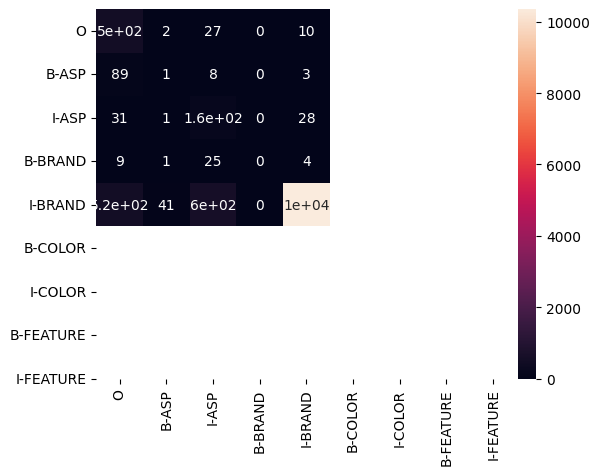

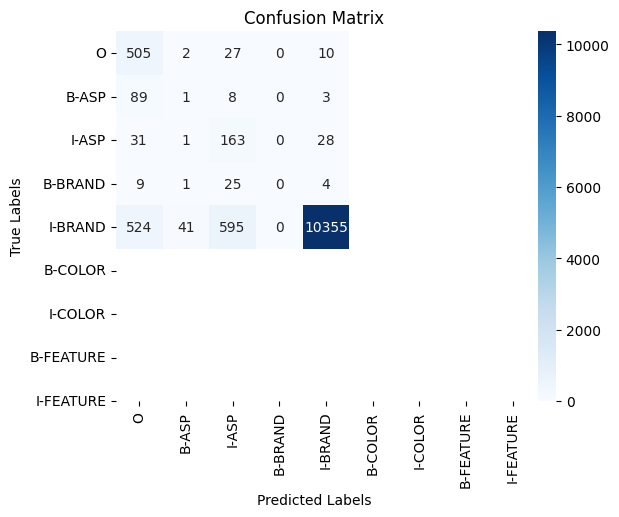

In [70]:
preds = trainer.predict(datasets['test'])
pred_labels = np.argmax(preds.predictions, axis=-1)
true_labels = preds.label_ids
y_true, y_pred = [], []
for pred, true in zip(pred_labels, true_labels):
    for p, t in zip(pred, true):
        if t != -100:
            y_true.append(id2label[t])
            y_pred.append(id2label[p])
print(classification_report(y_true, y_pred))

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# model.config.label2id = label2id
# model.config.id2label = id2label

# aspect_pipe = pipeline("token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# example = "HP laptops have great battery life and come in silver and black"
# results = aspect_pipe(example)

# for res in results:
#     print(f"{res['entity_group']} → {res['word']} ({res['score']:.2f})")


Device set to use cuda:0
The model 'PeftModelForTokenClassification' is not supported for token-classification. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DiffLlamaForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GemmaForTokenClassification', 'Gemma2ForTokenClassification', 'GlmForTokenClassification', 'GPT2ForTokenClassification', 'GPT2ForTokenClassificati

ASP → HP (0.53)
ASP → laptops (0.50)
ASP → battery life (0.53)


In [29]:
aspect_pipe = pipeline(
    "token-classification", 
    model=model, 
    tokenizer=tokenizer, 
    aggregation_strategy="simple"
)


Device set to use cuda:0
The model 'PeftModelForTokenClassification' is not supported for token-classification. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DiffLlamaForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GemmaForTokenClassification', 'Gemma2ForTokenClassification', 'GlmForTokenClassification', 'GPT2ForTokenClassification', 'GPT2ForTokenClassificati

In [32]:
results = aspect_pipe("The battery is bright and the hand bag is good.")

for res in results:
    print(f"Entity: {res['word']}, Type: {res['entity_group']}, Score: {res['score']}")


Entity: battery, Type: ASP, Score: 0.49513161182403564
Entity: hand bag, Type: ASP, Score: 0.42870256304740906


In [33]:
sentiment_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}


In [34]:
sentiment_df = []
for df in [train_df, eval_df, test_df]:
    for i, row in df.iterrows():
        text = row["text"]
        for ann in eval(row["annotations"]):
            asp, _, sent, _ = ann
            if asp != "null":
                formatted = {
                    "text": f"Aspect: {asp}. Sentence: {text}",
                    "label": sentiment_map[sent]  # Use the sentiment_map for conversion
                }
                sentiment_df.append(formatted)

sentiment_df = pd.DataFrame(sentiment_df)
sentiment_dataset = Dataset.from_pandas(sentiment_df)


In [ ]:
def tokenize_sentiment(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

sentiment_dataset = sentiment_dataset.map(tokenize_sentiment, batched=True)
sentiment_dataset = sentiment_dataset.train_test_split(test_size=0.1)
sentiment_dataset = sentiment_dataset.remove_columns([c for c in sentiment_dataset["train"].column_names if c not in ["input_ids", "attention_mask", "label"]])

sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=3)

sentiment_model = get_peft_model(sentiment_model, lora_config)
sentiment_model.print_trainable_parameters()


In [35]:

sentiment_args = TrainingArguments(
    output_dir="./deberta-sentiment-classifier",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=7,
    logging_dir="./logs",
    report_to="none"
)

sentiment_trainer = Trainer(
    model=sentiment_model,
    args=sentiment_args,
    train_dataset=sentiment_dataset["train"],
    eval_dataset=sentiment_dataset["test"],
    tokenizer=tokenizer
)

sentiment_trainer.train()

Map:   0%|          | 0/3130 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1151180748.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  sentiment_trainer = Trainer(


trainable params: 297,219 || all params: 184,721,670 || trainable%: 0.1609


No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.816400
1000,0.505000
1500,0.430600
2000,0.408400


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=2471, training_loss=0.5112206996669175, metrics={'train_runtime': 634.6376, 'train_samples_per_second': 31.071, 'train_steps_per_second': 3.894, 'total_flos': 1301607774125568.0, 'train_loss': 0.5112206996669175, 'epoch': 7.0})

In [37]:
eval_results = sentiment_trainer.evaluate(sentiment_dataset["test"])
print(eval_results)

{'eval_loss': 0.4393904209136963, 'eval_runtime': 4.9339, 'eval_samples_per_second': 63.438, 'eval_steps_per_second': 8.107, 'epoch': 7.0}


              precision    recall  f1-score   support

    negative       0.88      0.96      0.92       127
     neutral       0.00      0.00      0.00        23
    positive       0.88      0.94      0.91       163

    accuracy                           0.88       313
   macro avg       0.59      0.64      0.61       313
weighted avg       0.82      0.88      0.85       313



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


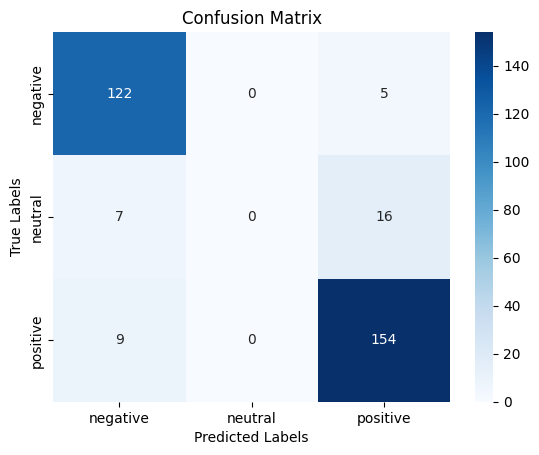

In [38]:
# Ensure that you have defined 'id2label' and 'label2id' properly
id2labelS = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2idS = {'negative': 0, 'neutral': 1, 'positive': 2}

# Evaluation
preds = sentiment_trainer.predict(sentiment_dataset["test"])
pred_labels = np.argmax(preds.predictions, axis=-1)
true_labels = preds.label_ids

# Prepare the lists for classification report
y_true, y_pred = [], []
for pred, true in zip(pred_labels, true_labels):
    if true != -100:  # Avoid padding label
        y_true.append(id2labelS[true])  # Append the true label
        y_pred.append(id2labelS[pred])  # Append the predicted label

# Print classification report
print(classification_report(y_true, y_pred))

# Confusion matrix and heatmap
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [40]:
# Final Inference Function
id2labelS = {0: 'negative', 1: 'neutral', 2: 'positive'}
sentiment_pipe = pipeline(
    "text-classification",
    model=sentiment_model,
    tokenizer=tokenizer,
    return_all_scores=True
)
def infer_aspects_and_sentiments(text):
    aspects = aspect_pipe(text)
    output = {}
    for asp in aspects:
        asp_text = asp["word"]
        input_text = f"Aspect: {asp_text}. Sentence: {text}"
        result = sentiment_pipe(input_text)
        pred_sent = sorted(result[0], key=lambda x: x["score"], reverse=True)[0]
        sentiment_label = id2labelS[int(pred_sent["label"].split('_')[1])]  # Map to human-readable label
        output[asp_text] = sentiment_label
    return output




Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForTokenClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DiffLlamaForSequenceClassifi

{'book': 'positive'}


In [44]:
# Example usage
example_text = "HP laptops have bad battery life and come in silver and black"
print(infer_aspects_and_sentiments(example_text))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


{'HP': 'negative', 'laptops': 'negative', 'battery life': 'negative', 'silver': 'negative'}


# **EValuate Base Model**

In [45]:
base_ner_model = AutoModelForTokenClassification.from_pretrained(
    model_ckpt,
    num_labels=3,
    label2id = {
    "O": 0,
    "B-ASP": 1, "I-ASP": 2,
    "B-BRAND": 3, "I-BRAND": 4,
    "B-COLOR": 5, "I-COLOR": 6,
    "B-FEATURE": 7, "I-FEATURE": 8
},
    id2label = {v: k for k, v in label2id.items()}
)

# Create token classification pipeline using base model
aspect_pipe_base = pipeline(
    "token-classification",
    model=base_ner_model,
    tokenizer=tokenizer,
    aggregation_strategy="simple"
)


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


In [46]:
base_sent_model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=3,
    id2label={0: 'negative', 1: 'neutral', 2: 'positive'},
    label2id={'negative': 0, 'neutral': 1, 'positive': 2}
)

# Sentiment classification pipeline using base model
sentiment_pipe_base = pipeline(
    "text-classification",
    model=base_sent_model,
    tokenizer=tokenizer,
    return_all_scores=True
)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


In [47]:
def infer_base_aspects_and_sentiments(text):
    aspects = aspect_pipe_base(text)
    output = {}
    for asp in aspects:
        asp_text = asp["word"]
        input_text = f"Aspect: {asp_text}. Sentence: {text}"
        result = sentiment_pipe_base(input_text)
        # Pick sentiment with highest score
        pred_sent = sorted(result[0], key=lambda x: x["score"], reverse=True)[0]
        sentiment_label = pred_sent["label"]
        output[asp_text] = sentiment_label
    return output


In [48]:
example_text = "The screen is beautiful but the battery life is terrible."
print(infer_base_aspects_and_sentiments(example_text))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'The screen is beautiful but the': 'positive', 'battery': 'positive', 'life is terrible': 'positive', '.': 'positive'}


In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_ckpt, num_labels=9)


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2934 [00:00<?, ? examples/s]

Map:   0%|          | 0/326 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Total Loss: 430.149018406868
              precision    recall  f1-score   support

       B-ASP       0.00      0.00      0.00       763
     B-BRAND       0.00      0.00      0.00         0
     B-COLOR       0.00      0.00      0.00         0
   B-FEATURE       0.00      0.00      0.00         0
       I-ASP       0.00      0.00      0.00       288
     I-BRAND       0.00      0.00      0.00         0
           O       0.99      0.16      0.27     11642

    accuracy                           0.14     12693
   macro avg       0.14      0.02      0.04     12693
weighted avg       0.91      0.14      0.25     12693



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


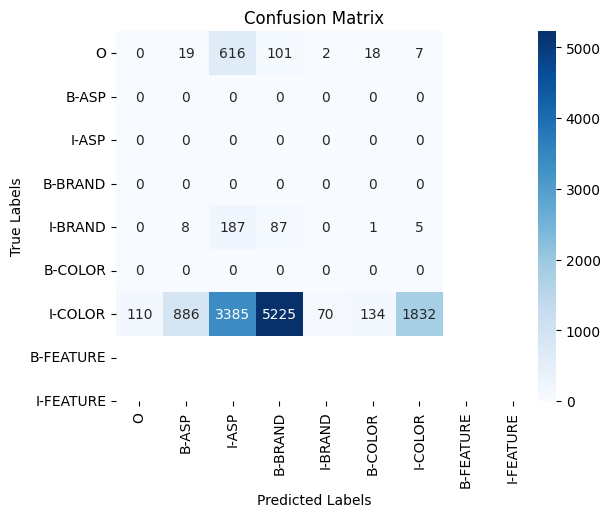

In [3]:
collator = DataCollatorForTokenClassification(tokenizer)
eval_loader = DataLoader(datasets['test'], batch_size=4, collate_fn=collator)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
y_true, y_pred = [], []
total_loss = 0  
with torch.no_grad():
    for batch in eval_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = outputs.loss  
        total_loss += loss.item()  

        pred_labels = torch.argmax(logits, dim=-1)

        
        for pred, true in zip(pred_labels, labels):
            for p, t in zip(pred, true):
                if t != -100:
                    y_true.append(id2label[t.item()])
                    y_pred.append(id2label[p.item()])


print(f"Total Loss: {total_loss}")


print(classification_report(y_true, y_pred))


conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
